In [1]:

from re import T
from socket import TCP_KEEPINTVL
import sys
#sys.path.insert(1, "../")

from typing import TYPE_CHECKING


from magicgui import magic_factory
from magicgui.widgets import ComboBox, Container, PushButton, SpinBox, FileEdit, FloatSpinBox, Label, TextEdit, CheckBox
from magicgui.widgets import create_widget, Widget
from qtpy.QtWidgets import QHBoxLayout, QPushButton, QWidget

import numpy as np

import pandas as pd
from matplotlib import pyplot as plt


from scipy.ndimage import gaussian_filter1d as gaussian_filter1d
from scipy.signal import find_peaks
import os

from pose_viewer._loader import ZebData, HyperParams
from torch.utils.data import DataLoader, random_split, Subset
import torch
from pose_viewer.models import st_gcn_aaai18_pylightning_3block, c3d

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.stochastic_weight_avg import StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import yaml
import torch.nn as nn

import pims
import tables as tb
#from skimage.segmentation import watershed
#from skimage.feature import peak_local_max
#from scipy import ndimage as ndi
#from sklearn.manifold import TSNE
#from matplotlib.animation import FuncAnimation
import time
import scipy.stats as st

import napari_plot
from napari_plot._qt.qt_viewer import QtViewer
try:
    from napari_video.napari_video import VideoReaderNP
except:
    print("no module named napari_video. pip install napari_video")
    import time

try:
    import cupy as cp
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
except:
    print("no cuda support")

In [2]:
import torch.nn.functional as F

In [3]:
from pose_viewer._widget import ExampleQWidget

In [4]:
import napari

In [5]:
viewer = napari.Viewer()

In [6]:
wid = ExampleQWidget(viewer)

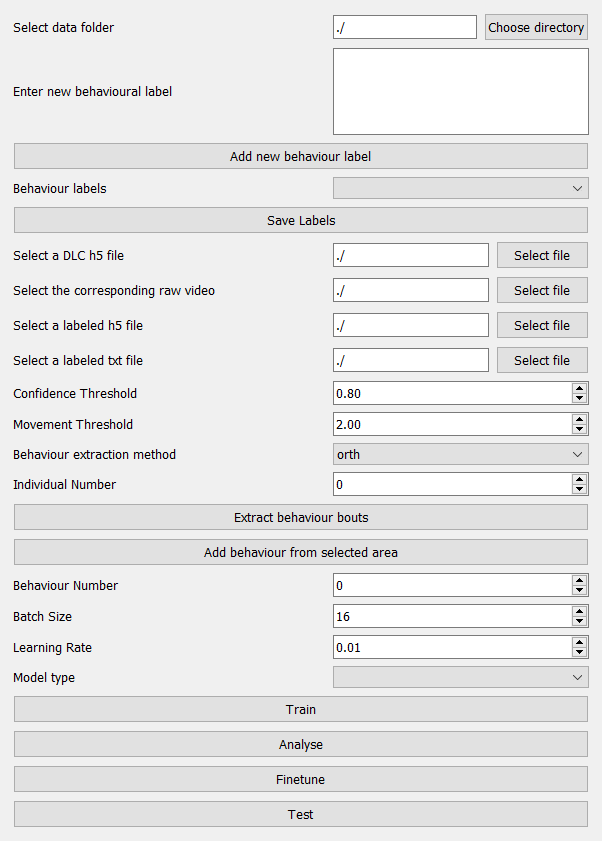

In [7]:
wid

In [8]:
wid.decoder_dir_changed(r"D:\DecoderData\DLCAnalyser\OFT")

Decoder Data Folder is D:\DecoderData\DLCAnalyser\OFT
Center node is 5
Number of nodes is 13
decoder config is {'data_cfg': {'T': 'None', 'V': 13, 'fps': 25, 'T2': 300, 'numLabels': 3, 'denominator': 8, 'center': 5, 'classification_dict': {0: 'Supported', 1: 'Unsupported', 2: 'Grooming', 3: 'Start/End', 4: 'StartEnd', 5: 'Jumping', 6: '_DEFAULT'}, 'augmentation': 1000, 'align': True, 'labels_to_ignore': ['StartEnd', 'Start/End', 'Jumping', '_DEFAULT'], 'dataset': 'OFT', 'keypoints': ['nose', 'headcentre', 'neck', 'earl', 'earr', 'bodycentre', 'bcl', 'bcr', 'hipl', 'hipr', 'tailbase', 'tailcentre', 'tailtip']}, 'train_cfg': {'devices': 1, 'auto_lr': True, 'accelerator': 'gpu', 'graph_layout': 'mouse1', 'dropout': 0, 'num_channels': 3, 'num_workers': 0, 'transform': 'None', 'backbone': 'ST-GCN'}}


In [9]:
### get files used for testing
all_files = [os.path.join(wid.decoder_data_dir, file) for file in os.listdir(wid.decoder_data_dir) if "classification.h5" in file]
nfiles= len(all_files)

train_proportion = int(0.85 * nfiles)

train_files = all_files[: train_proportion]
test_files = all_files[train_proportion:]

In [10]:
test_files

['D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_54.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_58.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_6.mp4_classification.h5']

In [11]:
test_files_coords = [r"D:\DecoderData\DLCAnalyser\OFT\43_03_A_190507151557DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                     r"D:\DecoderData\DLCAnalyser\OFT\53_04_A_190507135800DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                     r"D:\DecoderData\DLCAnalyser\OFT\17_02_A_190507120259DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv"]

In [12]:
train_files_coords = [r"D:\DecoderData\DLCAnalyser\OFT\3_01_A_190507121945DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\17_02_A_190507120259DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\53_04_A_190507135800DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\43_03_A_190507151557DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\37_03_A_190507134213DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\49_04_A_190507125609DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\45_04_A_190507114741DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\13_01_A_190507145949DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\57_04_A_190507150030DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\12_01_A_190507144429DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\23_02_A_190507135734DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\18_02_A_190507122004DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\25_02_A_190507142904DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\8_01_A_190507134142DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\58_04_A_190507151611DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\40_03_A_190507142917DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\48_04_A_190507123817DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\15_01_A_190507153142DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\26_02_A_190507144444DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",
                        r"D:\DecoderData\DLCAnalyser\OFT\21_02_A_190507131119DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv",]

In [13]:
train_files

['D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_11.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_12.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_14.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_15.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_16.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_23.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_24.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_38.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_39.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_41.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_43.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_44.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_49.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_5.mp4_classification.h5',
 'D:\\DecoderData\\DLCAnalyser\\OFT\\OFT_50.mp4_c

In [14]:
h5_file = train_files_coords[0]

In [15]:
wid.read_coords(h5_file)


Selecting bodypoints ['nose', 'headcentre', 'neck', 'earl', 'earr', 'bodycentre', 'bcl', 'bcr', 'hipl', 'hipr', 'tailbase', 'tailcentre', 'tailtip']


In [16]:
wid.individual_changed(1)

New individual is individual 1


AttributeError: 'ExampleQWidget' object has no attribute 'im'

In [ ]:
wid.points.shape

In [17]:
## get egocentric
reshap = wid.points.reshape(wid.n_nodes, -1, 3)
center = reshap[wid.center_node, :, 1:] #selects x,y center nodes
wid.egocentric = reshap.copy()
wid.egocentric[:,:, 1:] = reshap[:, :, 1:]-center.reshape((-1, *center.shape)) # subtract center nodes


In [18]:
wid.zebdata = ZebData()
points = wid.egocentric[:, :, 1:]
points = np.swapaxes(points, 0, 2)
ci_array = wid.ci.to_numpy()
ci_array = ci_array.reshape((*ci_array.shape, 1))
cis = np.swapaxes(ci_array, 0, 2)

In [21]:
wid.chkpt_dropdown.choices

('version_0\\epoch=9-val_loss=0.51-val_acc=0.79.ckpt',
 'version_1\\epoch=6-val_loss=0.53-val_acc=0.78.ckpt',
 'version_2\\epoch=13-val_loss=0.52-val_acc=0.79.ckpt',
 'version_3\\epoch=15-val_loss=0.50-val_acc=0.80.ckpt',
 'version_4\\epoch=14-val_loss=0.41-val_acc=0.84.ckpt',
 'version_5\\epoch=16-val_loss=0.39-val_acc=0.82.ckpt',
 'version_6\\epoch=13-val_loss=0.39-val_acc=0.85.ckpt',
 'version_7\\epoch=10-val_loss=0.45-val_acc=0.82.ckpt')

In [22]:
from pose_viewer.utils import Animation

In [25]:
from IPython.display import HTML, display

In [ ]:
### Train on frame by frame

In [26]:
# N, C, T, V, M - don't ignore confidence interval but give option of removing 
N = wid.dlc_data.shape[0] # this is number of frames
C = wid.config_data["train_cfg"]["num_channels"]
T2 = wid.config_data["data_cfg"]["T2"]
denominator = wid.config_data["data_cfg"]["denominator"]
T_method = wid.config_data["data_cfg"]["T"]
fps = wid.config_data["data_cfg"]["fps"]
T = 50
V = points.shape[2]
M = 1
batch_size = wid.batch_size
#bouts = np.zeros((N, C, T, V, M))


data_cfg, graph_cfg, hparams = wid.initialise_params()



# load model check point, 
log_folder = os.path.join(wid.decoder_data_dir, "lightning_logs")
wid.chkpt =  os.path.join(log_folder, wid.chkpt_dropdown.choices[-2])  # spinbox

model = st_gcn_aaai18_pylightning_3block.ST_GCN_18(in_channels = wid.numChannels, 
                                                   num_workers=wid.num_workers,
                                           num_class = wid.numlabels, 
                                           graph_cfg = graph_cfg, 
                                           data_cfg = data_cfg, 
                                           hparams = hparams).load_from_checkpoint(wid.chkpt, 
                                                                                   in_channels = wid.numChannels, 
                                                                                   num_workers=wid.num_workers,
                                                                                   num_class = wid.numlabels, 
                                                                                   graph_cfg = graph_cfg, 
                                                                                   data_cfg = data_cfg,
                                                                                   hparams = hparams)
if wid.accelerator == "gpu":
    device = torch.device("cuda")
elif wid.accelerator == "cpu":
    device = torch.device("cpu")
model.freeze()
model.to(device)


predictions = []
probabilities = []
n_batches = int(np.ceil((N-T)/batch_size))
with torch.no_grad():
                



    for batch in range(n_batches):
        start_n = int(batch * batch_size)
        padded_bouts = np.zeros((batch_size, C, T2, V, M))
        # loop through movement windows when behaviour occuring 
        for n in range(batch_size):
            batch_n = start_n + n

            new_start = batch_n
            new_end = batch_n + T 

            bhv = points[:, new_start:new_end] # why do I have to subset the data from here
            ci = cis[:, new_start:new_end]
            ci = ci.reshape((*ci.shape, 1))

            # switch to x, y from y, x
            bhv_rs = bhv.copy()
            bhv_rs[1] = bhv[0]
            bhv_rs[0] = bhv[1]
            bhv = bhv_rs

            # reflect y to convert to cartesian friendly coordinate system - is this needed if coordinates are egocentric?
            bhv = bhv.reshape((*bhv.shape, 1)) # reshape to N, C, T, V, M
            y_mirror = np.array([[1, 0],
                                [0, -1]])

            for frame in range(bhv.shape[1]):
                bhv[:2, frame] = (bhv[:2, frame].T @ y_mirror).T


            # align function takes shape N, C, T, V, M
            bhv_align = wid.zebdata.align(bhv)

            bouts = np.zeros((C, T, V, M))
            bouts[:2] = bhv_align  # not sure why this is different
            bouts[2] = ci[0]

            padded_bouts[n] = wid.zebdata.pad(bouts, T2)
        
        wid.zebdata.data = padded_bouts
        wid.zebdata.labels = np.zeros(padded_bouts.shape[0])
        dataloader = DataLoader(wid.zebdata, batch_size = wid.batch_size, num_workers = wid.num_workers, pin_memory = False)


        # feed to model
        #wid.predict_behaviours()
        output = model(next(iter(dataloader))[0].to(device))
        wid.predictions = output.cpu()
        label_dict = wid.config_data["data_cfg"]["classification_dict"]

        #oftmax = nn.Softmax(dim = 1)
        preds = torch.argmax(wid.predictions, dim=1).numpy()
        #probs = torch.max(softmax(wid.predictions), dim = 1).values.numpy()
        probs = wid.predictions
        
        #print(preds, probs)

        predictions.extend(preds)
        probabilities.extend(probs)
    

transform is None
Augmenting data 1000
Label dict is {'Supported': 0, 'Unsupported': 1, 'Grooming': 2, 'Start/End': 3, 'StartEnd': 4, 'Jumping': 5, '_DEFAULT': 6}


ValueError: could not broadcast input array from shape (2,49,13,1) into shape (2,50,13,1)

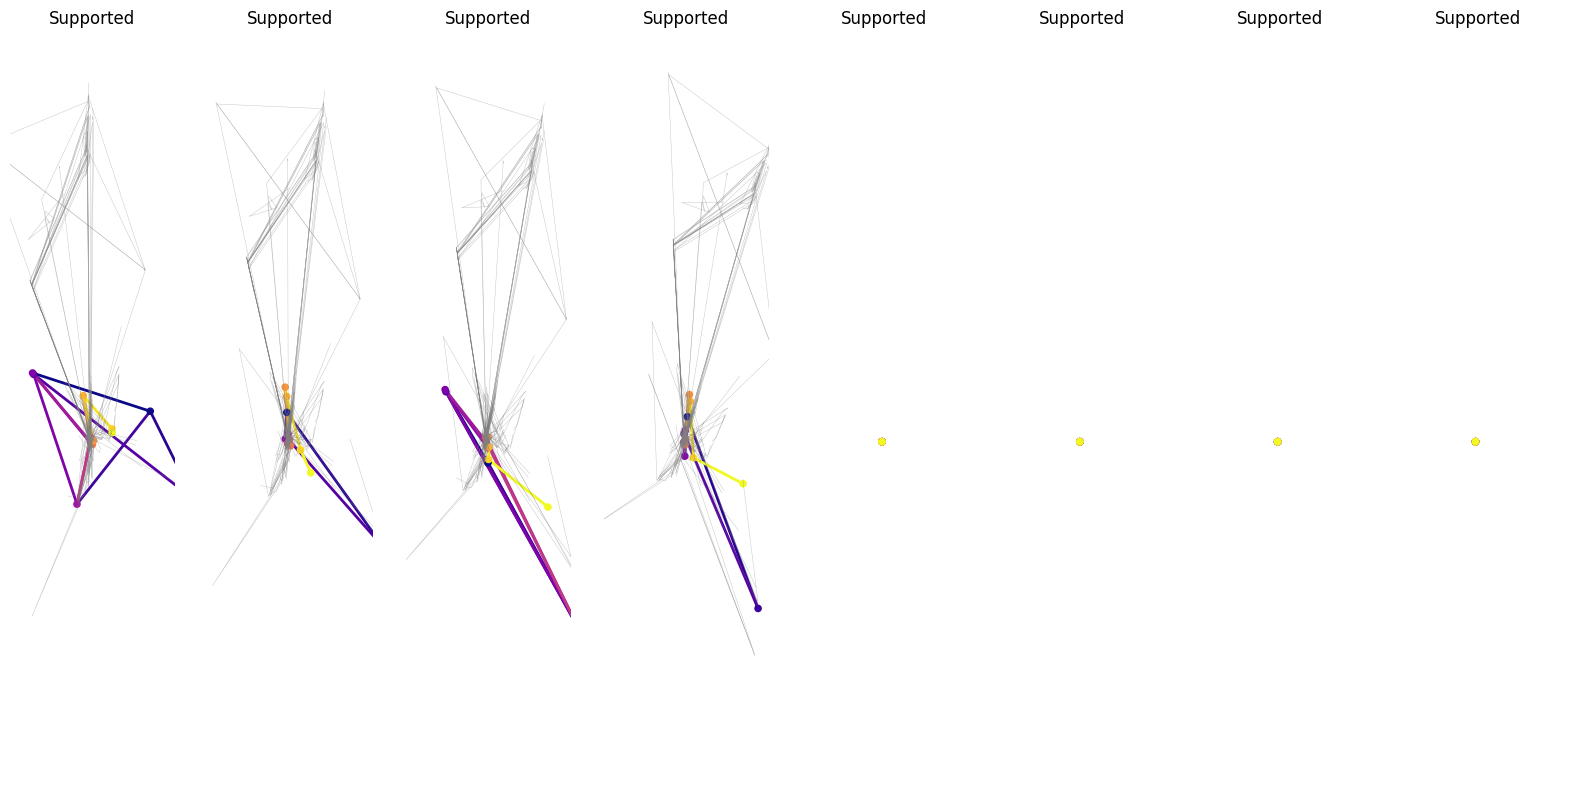

In [27]:
skeleton = [[0, 3], [0, 1], [0, 4], [1, 2], [2, 3], [2, 4],
                             [3, 6], [3, 5], [4, 7], [4, 5], [5, 7], [5, 6], 
                             [6, 8], [7, 9], [5, 8], [5, 9], [5, 10], [9, 10],
                             [8, 10], [10, 11], [11, 12]]
zebdata = ZebData()
zebdata.data = padded_bouts[:, :, :50]
zebdata.labels = np.zeros(padded_bouts.shape[0])
anima = Animation(dataset = zebdata, skeleton = skeleton, label_dict = wid.class_dict, shuffle = False, normalise = True)
anima.animate()
display(HTML(anima.ani.to_jshtml()))

In [29]:
cis.shape

(1, 15253, 13)

In [30]:
# concatenate probabilities and plot over ethogram
all_probs = np.array([prob.numpy() for prob in probabilities])
all_probs

array([[-25.447783, -43.504364,  79.73939 ],
       [-15.83861 , -36.126495,  62.363995],
       [-19.096146, -40.91102 ,  69.190384],
       ...,
       [-34.771057, -81.01063 , 143.44936 ],
       [-37.008415, -74.2964  , 138.4359  ],
       [-42.150497, -80.52332 , 151.5285  ]], dtype=float32)

In [31]:
from scipy.stats import median_abs_deviation as mad

In [32]:
norm_probs = (all_probs - np.median(all_probs, axis=0)) / (mad(all_probs, axis=0))

In [33]:
all_probs.min(axis=0).shape

(3,)

In [34]:
%matplotlib widget

In [35]:
all_probs = torch.from_numpy(all_probs)).numpy()

SyntaxError: unmatched ')' (2079592388.py, line 1)

In [43]:

#norm_probs2[norm_probs2 <1.5] = -1

In [44]:
## Ground truth 
# load classification data
class_file = tb.open_file(train_files[0], mode = "r")
classification_data = wid.read_classification_h5(class_file)

gt = np.zeros(N)
gt[:] = -1


for bout, data in classification_data[1].items():
    idx = np.arange(data["start"], data["stop"])
    label = wid.label_dict[data["classification"]]
    gt[idx] = label



# iterate through all bouts and get start and stop frames
# fill a nan numpy array with those start and stops and labels in either semantic or number form


In [45]:
def plot_etho(ax, labels):
    

    true_idx = {}

    for label in np.unique(labels):
        label_idx = np.where(labels == label)[0]
        true_idx[label] = label_idx
        
    ax.eventplot(list(true_idx.values()), lineoffsets = list(true_idx.keys()), alpha = 0.5, color = "m")
    return ax

In [74]:
ci_filter= cis[0].mean(axis=1) < 0.99
ci_filter.sum()

2261

In [78]:
norm_probs2 = norm_probs.copy()
norm_probs2[ci_filter[:norm_probs2.shape[0]]] = np.nan

In [79]:
norm_probs2[ci_filter[:norm_probs2.shape[0]]].shape

(2215, 3)

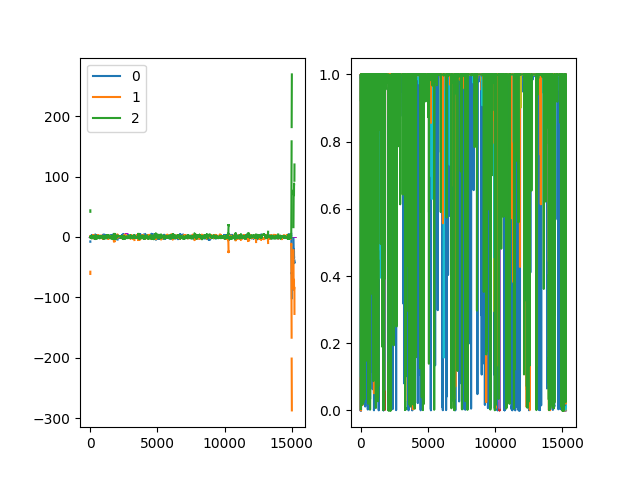

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True)
plot_etho(ax1, gt)
ax1.plot(norm_probs2, label = [0, 1, 2])
ax1.legend()
ax2.plot(cis[0])

In [68]:
ci_filter.sum()

172

In [63]:
ci_filter[:norm_probs2.shape[0]]

array([ True,  True,  True, ..., False, False, False])

In [51]:
norm_probs.shape

(15200, 3)

In [116]:
#like_filter = np.array(probabilities) > 0.7
prob2 = np.array(probabilities).copy()
pred2 = np.array(predictions).copy()

#pred2[~like_filter] = -1
gt_copy = gt.copy()[:pred2.shape[0]]
gt_copy[np.isnan(gt_copy)] = -1
gt_copy[gt_copy>=3] = -1


prob_filter = prob2 < 0
pred2[prob_filter] = -1
print(classification_report(gt_copy, pred2))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      9913
         0.0       0.22      0.54      0.32      2797
         1.0       0.22      0.67      0.33      2059
         2.0       0.14      0.86      0.25       383

    accuracy                           0.21     15152
   macro avg       0.15      0.52      0.22     15152
weighted avg       0.08      0.21      0.11     15152



D:\poseviewer1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\poseviewer1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\poseviewer1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
idx = {}

for label in np.unique(pred2):
    label_idx = np.where(pred2 == label)[0]
    idx[label] = label_idx
    


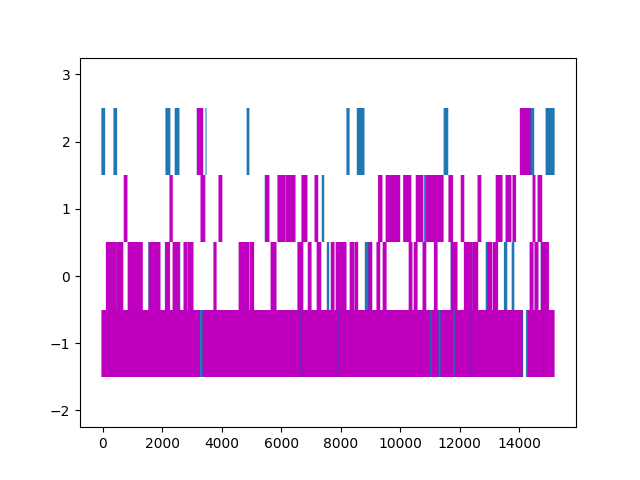

In [110]:
# def function to convert frame label to ethogram
# try eventplot

fig, ax = plt.subplots()
ax.eventplot(list(idx.values()), lineoffsets = list(idx.keys()), alpha = 0.5)


In [111]:
pred2[prob_filter | (np.isin(1, 2))]

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [27]:
y_true = gt_copy.copy()
y_pred = pred2.copy()
label = 0
label_filter = y_true != label

y_true[label_filter] = -1
y_pred[label_filter] = -1

y_prob = prob2.copy()


In [32]:
y_true, y_pred

(array([-1., -1., -1., ..., -1., -1., -1.]),
 array([-1, -1, -1, ..., -1, -1, -1], dtype=int64))

In [62]:
idx

{0: array([   91,    92,    93, ..., 14928, 14929, 14930], dtype=int64),
 1: array([   39,    40,    41, ..., 14883, 14884, 14885], dtype=int64),
 2: array([    0,     1,     2, ..., 15149, 15150, 15151], dtype=int64)}

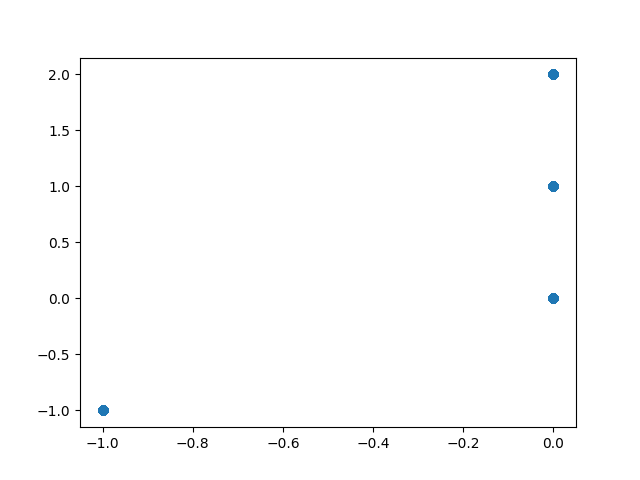

In [43]:
%matplotlib widget
fig, ax = plt.subplots()
ax.scatter(y_true, y_pred)

In [37]:
gt_copy, pred2

(array([-1., -1., -1., ..., -1., -1., -1.]),
 array([2, 2, 2, ..., 2, 2, 2], dtype=int64))

In [38]:
from sklearn.metrics import classification_report


              precision    recall  f1-score   support

        -1.0       0.67      0.85      0.75      9913
         0.0       0.32      0.12      0.18      2797
         1.0       0.47      0.09      0.15      2059
         2.0       0.25      0.70      0.37       383

    accuracy                           0.61     15152
   macro avg       0.43      0.44      0.36     15152
weighted avg       0.57      0.61      0.55     15152



In [ ]:
from scipy.optimize import least_squares

In [ ]:
least_squares(objective, 0.99, bounds=(0.4, 1))

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           x: [ 9.900e-01]
        cost: 1490.0
         jac: [[ 0.000e+00]
               [ 0.000e+00]
               ...
               [ 0.000e+00]
               [ 0.000e+00]]
        grad: [ 0.000e+00]
  optimality: 0.0
 active_mask: [0]
        nfev: 1
        njev: 1

In [ ]:
gt_copy[np.where(pred2 !=2)[0]]

array([-1., -1., -1., ..., -1., -1., -1.])

In [ ]:
print(classification_report(gt_copy[:pred2.shape[0]], pred2))

              precision    recall  f1-score   support

        -1.0       0.67      0.40      0.50      9913
         0.0       0.25      0.65      0.36      2797
         1.0       0.30      0.19      0.24      2059
         2.0       0.06      0.09      0.07       383

    accuracy                           0.41     15152
   macro avg       0.32      0.33      0.29     15152
weighted avg       0.53      0.41      0.43     15152



### End

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def objective(prob):
    
    prob_filter = y_prob < prob
    
    y_pred[prob_filter] = -1
    
    loss = y_true - y_pred
    
    return loss

In [ ]:
y_true = gt_copy[

In [ ]:
def model(y_true, y_pred):
    y_pred[np.array(prob2) > 0.9]
    return # prediction

In [ ]:
# read coords of a h5 file
# ground truth is that classfication data - convert into sequence
# load model
# feed coords into model